In [20]:

%load_ext blackcellmagic
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.model_selection import (RepeatedKFold, cross_val_score,
                                     train_test_split)

from src.dataloader import DataLoader

from sklearn.metrics import r2_score

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [14]:
# set output to just 2 sig digits
np.set_printoptions(precision=2)

# Import the dataframe from our dataloader class
df = DataLoader().get_data_frame(date="Jun22_2020")

feature_names = list(df.columns)[1:]

# feature selection by SelectKBest, Pearson's corr coeff
sel_features = ['blue-blue-444', 'green-531-red', 'nir-red-edge', 'nir-red-edge-740']

# X and y
# feat_idx = df.columns[df.columns.isin(sel_features)].values
# print(X.shape)
X = df.loc[:, sel_features].values
y = df['yield'].values

# train test Split (0.7/0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=26, shuffle=True)

# test validate split (0.3 split into 0.15/0.15)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, random_state=26, shuffle=True)
# Important Note! Feature selection should be done AFTER test/train split, to avoid information leakage


# Standard scaling features
Standardization of features according to: x'=(x-µ)/ σ. Sets mean to 0 and unit variance to 1. <br>

Z-score Feature Scaling: https://developers.google.com/machine-learning/data-prep/transform/normalization

Greek symbols in ascii are produced like so:<br>
µ = Alt + 230 <br>
σ = Alt + 229 <br>
Φ = Alt + 232 <br>
<br>
https://www.keynotesupport.com/internet/special-characters-greek-letters-symbols.shtml

In [15]:
#  train the scaler ONLY on the training set. Then use it to scale train/test/val
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train) # trains the scaler using fit on X_train, then transforms X_train as well
X_test = scaler.transform(X_test) # no fit, transforms using data from fit() stored in the scaler
X_val = scaler.transform(X_val)


In [19]:

# #### Ridge regression model


# define Ridge regression linear model
lm = Ridge(alpha=1.0)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = np.absolute(cross_val_score(lm, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=1))
print(f"Mean MAE: {np.mean(scores)} ({np.std(scores)})")

# fit model
lm.fit(X_train, y_train)




Mean MAE: 115.5706969264516 (38.26029529388733)
coeff: [  24.8    18.55 -118.75  148.79], intercept: 840.9064347574997


coeff: [  24.8    18.55 -118.75  148.79], intercept: 840.9064347574997


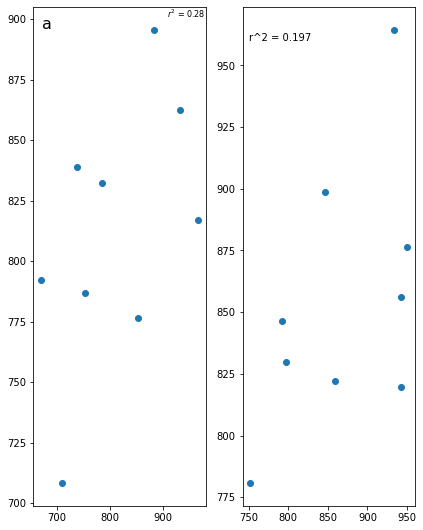

In [23]:
# test predictions
y_pred_t = lm.predict(X_test)
print(f"coeff: {lm.coef_}, intercept: {lm.intercept_}")

r2 = r2_score(y_test, y_pred_t)

# validation predictions
y_pred_v = lm.predict(X_val)
r2 = r2_score(y_val, y_pred_v)

# Display the images as one figure.
fig, axs = plt.subplots(1, 2)

axs[0].scatter(y_test, y_pred_t)
axs[0].annotate(
    "a",
    xy=(0.05, 0.98),
    xycoords="axes fraction",
    fontsize=16,
    horizontalalignment="left",
    verticalalignment="top",
)
axs[0].annotate(
    f"$r^2$ = {round(r2_score(y_test, y_pred_t), 2)}",
    xy=(1, 1),
    xycoords="axes fraction",
    fontsize=8,
    horizontalalignment="right",
    verticalalignment="top",
)


axs[1].scatter(y_val, y_pred_v)
axs[1].annotate("r^2 = {:.3f}".format(r2_score(y_val, y_pred_v)), (750, 960))

fig.tight_layout()
fig.set_figheight(8)